# Experimento 1: Itera√ß√£o de valor

In [1]:
# Importa√ß√µes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

In [2]:
# Ambiente: Navega√ß√£o no Labirinto (gridworld)

class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navega√ß√£o em labirinto.

        Par√¢metros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimens√µes da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transi√ß√£o
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transi√ß√£o para estado ruim
        self.r_target = rewards[2]    # transi√ß√£o para estado alvo
        self.r_other = rewards[3]     # demais transi√ß√µes

        # Espa√ßo de a√ß√µes: dicion√°rio com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espa√ßo de recompensas: lista de recompensas poss√≠veis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # n√∫mero total de estados
        self.n_states = self.n_rows * self.n_cols

        # n√∫mero total de a√ß√µes
        self.n_actions = len(self.action_space)

        # n√∫mero total de recompensas poss√≠veis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transi√ß√£o: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        self.agent_pos = (0, 0)  # posi√ß√£o inicial do agente

        self._init_dynamics()  # inicializa as din√¢micas de transi√ß√£o e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transi√ß√£o e recompensa com base
        na estrutura do ambiente e regras de movimenta√ß√£o.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento √© v√°lido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transi√ß√£o (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determin√≠stico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)


    def reset(self):
        """Reinicia a posi√ß√£o do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao):
        """
        Executa uma a√ß√£o no ambiente e atualiza a posi√ß√£o do agente.

        Par√¢metros:
        - acao: √≠ndice da a√ß√£o a ser executada (0 a 4)

        Retorna:
        - nova posi√ß√£o do agente (linha, coluna)
        - recompensa recebida
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_destino = self.agent_pos[0] + d_linha
        coluna_destino = self.agent_pos[1] + d_coluna
        destino = (linha_destino, coluna_destino)

        # Se movimento for inv√°lido ou entrada proibida, permanece
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino
        return self.agent_pos, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posi√ß√£o est√° dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: c√©lula ruim
        - r_target: c√©lula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para √≠ndice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte √≠ndice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

In [3]:
# Fun√ß√µes auxiliares para visualiza√ß√£o

def plot_policy(env, policy, ax=None):
    fig, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title("Pol√≠tica")
    plt.show()

    return

def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)


def plot_valores_de_estado(valores_estado, ambiente):
    plt.figure(figsize=(ambiente.n_rows, ambiente.n_cols))
    ax = sns.heatmap(
        data=valores_estado.reshape(ambiente.n_rows, ambiente.n_cols),
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor='gray',
    )
    ax.set_title(r"Valores de Estado (V(s))")
    plt.tight_layout()
    plt.show()


def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # R√≥tulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # R√≥tulos das linhas (a√ß√µes)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"A√ß√µes")
    ax.set_title(r"Valores de a√ß√£o (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padr√£o (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualiza√ß√£o do Labirinto")
    plt.tight_layout()
    plt.show()

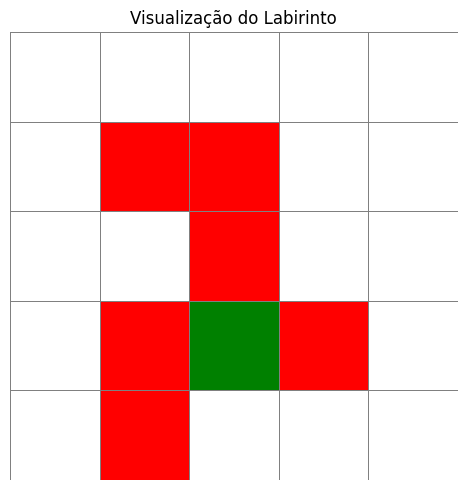

In [52]:
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=[-10, -10, 1, 0]
    )
plot_labirinto(ambiente)

In [62]:
def iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000):
    """
    Implementa o algoritmo de Itera√ß√£o de Valor para encontrar a pol√≠tica √≥tima.

    Par√¢metros:
    - ambiente: inst√¢ncia da classe AmbienteNavegacaoLabirinto
    - gamma: fator de desconto (0 < gamma <= 1)
    - theta: limiar m√≠nimo de varia√ß√£o para considerar converg√™ncia
    - max_iteracoes: n√∫mero m√°ximo de itera√ß√µes permitidas

    Retorna:
    - vetor de valores de estado V (numpy array) para todos os estados
    - matriz de valores de a√ß√£o Q (numpy array) para todos os pares (estado, a√ß√£o)
    - pol√≠tica √≥tima (dicion√°rio de estado para a√ß√£o)
    """

    # Informa√ß√µes √∫teis do ambiente:
    # n√∫mero de estados: ambiente.n_states
    # n√∫mero de a√ß√µes: ambiente.n_actions
    # n√∫mero de recompensas (√∫nicas): ambiente.n_rewards
    # Tensor de probabilidade de recompensas: P(r|s,a): ambiente.reward_probabilities shape=(ambiente.n_rewards, ambiente.n_states, ambiente.n_actions)
    # recompensas: ambiente.recompensas_possiveis (ambiente.recompensas_possiveis[i] com probabilidade ambiente.reward_probabilities[i,s,a])
    # Tensor de probabilidades de transi√ß√£o: P(s'|s,a): ambiente.state_transition_probabilities shape=(ambiente.n_states, ambiente.n_states, ambiente.n_actions)


    ######################################################################################
    # C√≥digo da itera√ß√£o de valor aqui

    # Deve calcular:
    # Valores de estado V (numpy array) para todos os estados (shape = (ambiente.n_states, ))
    # Valores de a√ß√£o Q (numpy array) para todos os estados (shape = (ambiente.n_states, ambiente.n_actions))
    # pol√≠tica √≥tima como dicion√°rio {estado - tupla: melhor_acao - int 0 a 4} (dica: usar ambiente.index_to_state(estado))
    
    
    
    # vetor com o valor de cada estado
    V = np.zeros(ambiente.n_states, dtype=float)
    
    # matriz para o valor de cada a√ß√£o de um estado[[0,0,0,1,1],[...]...]
    Q = np.zeros(shape=(ambiente.n_states, ambiente.n_actions))
        
    # Loop principal
    for k in range(max_iteracoes):
        delta = 0.0
        V_novo = np.zeros_like(V)
        for estado in range(ambiente.n_states):
                        
            for acao in range(ambiente.n_actions):
                recompensa_esperada = np.sum(
                    ambiente.reward_probabilities[:, estado, acao]
                    * ambiente.recompensas_possiveis
                )
                
                valor_futuro_esperado = np.sum(
                    ambiente.state_transition_probabilities[:, estado, acao] * V
                )
                
                Q[estado, acao] = recompensa_esperada + (gamma * valor_futuro_esperado)
                
                # print(f"Estado: {estado}")
                # print(f"A√ß√£o  : {acao}")
                # print(f"RE    : {recompensa_esperada}")
                # print(f"Q({estado},{acao}): {Q[estado, acao]}")    
            
            V_novo[estado] = np.max(Q[estado])
            delta = max(delta, abs(V_novo[estado] - V[estado]))
            
        V = V_novo
        
        if delta < theta:
            print(f"Convergiu com {k+1} intera√ß√µes.")
            break
    else:
        print(f"Convergiu com o m√°ximo de intera√ß√µes")
                
                
    politica = {}
    for estado in range(ambiente.n_states):
        melhor_acao = int(np.argmax(Q[estado]))
        coord_estado = ambiente.index_to_state(estado)
        politica[coord_estado] = melhor_acao
        
    # print(politica)
    return V, Q, politica

Convergiu com 133 intera√ß√µes.


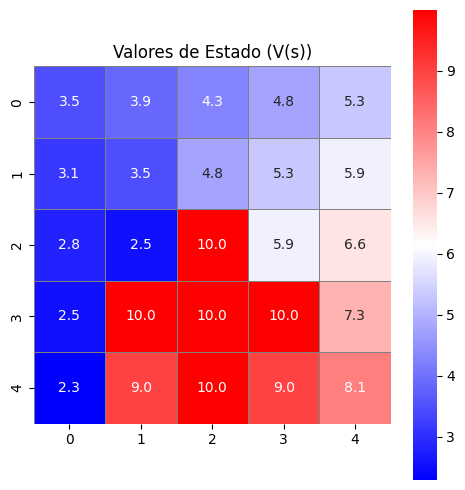

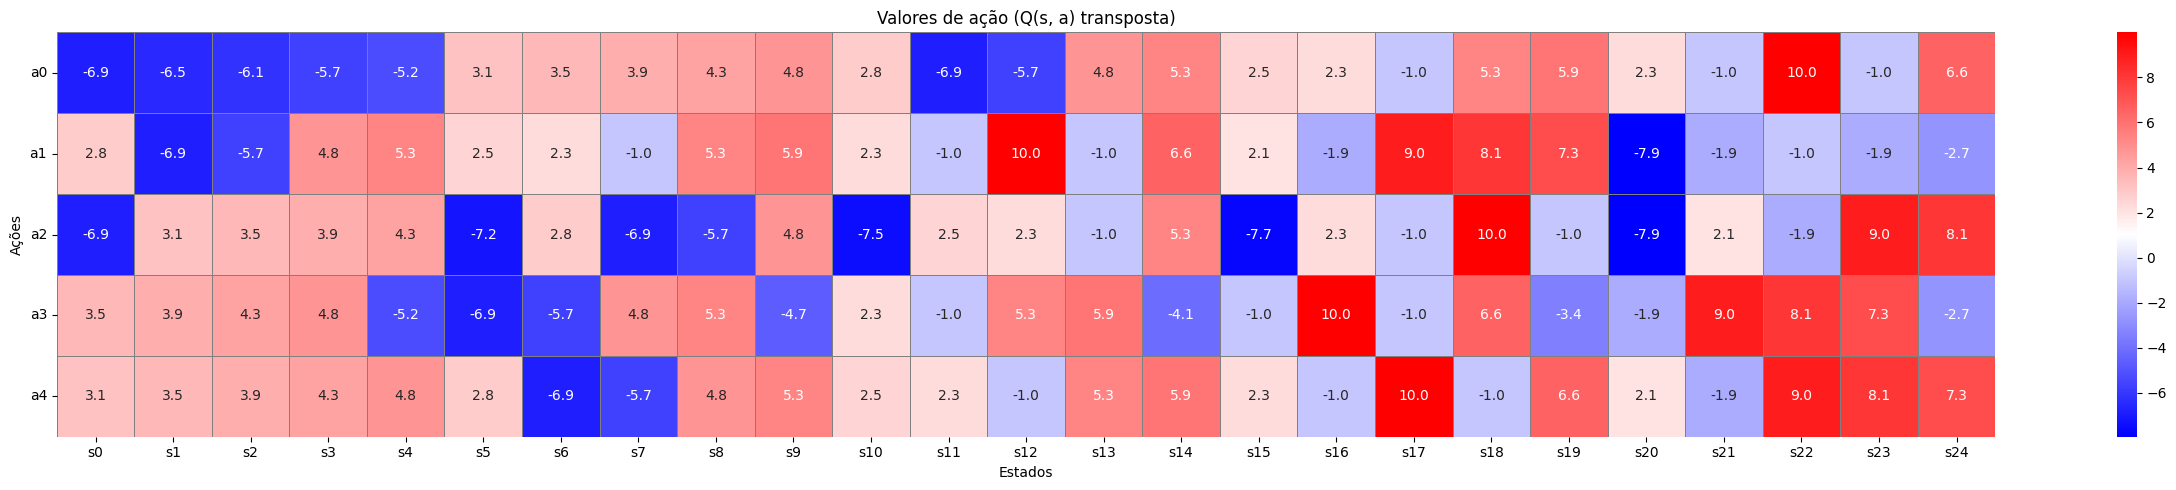

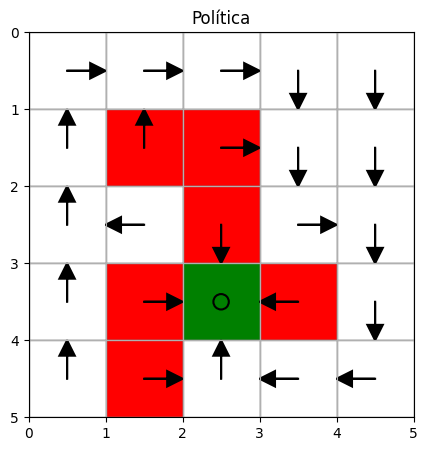

In [64]:
# TESTADO ALGORITMO

V, Q, politica = iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000)

plot_valores_de_estado(V, ambiente)

plot_valores_de_acao(Q)

plot_policy(ambiente, politica)

# Tarefa:

1. Observar e reportar o efeito de diferentes valores da taxa de desconto (por exemplo: gamma = 0, 0.5 e 0.9)
2. Observar e reportar o efeito r_bad = -1 ao inv√©s de -10
3. Observar e reportar o efeito de uma transforma√ß√£o afim em todas as recompensas, isto √©,
[r_boundary, r_bad, r_target, r_other] = [-1, -10, 1, 0] -> a * [-1, -10, 1, 0] + b para todo r

Entregar o PDF do notebook no colab (c√≥digo + relat√≥rio em markdown)

# Influencia da taxa de desconto ùõæ



In [76]:
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=[-10, -1, 1, 0]
    )

V1, Q1, politica1 = iteracao_de_valor(ambiente, gamma=0, theta=1e-6, max_iteracoes=1000)
V2, Q2, politica2 = iteracao_de_valor(ambiente, gamma=0.5, theta=1e-6, max_iteracoes=1000)
V3, Q3, politica3 = iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000)

Convergiu com 2 intera√ß√µes.
Convergiu com 21 intera√ß√µes.
Convergiu com 133 intera√ß√µes.


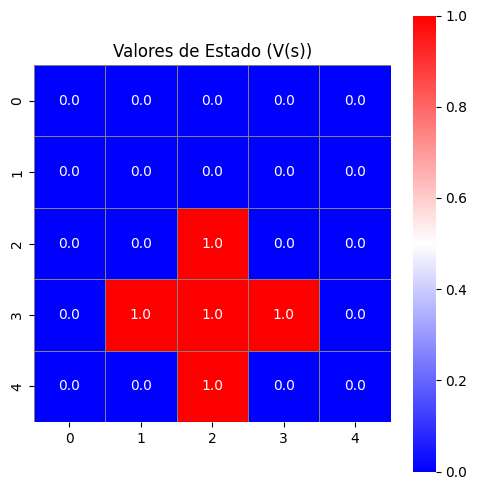

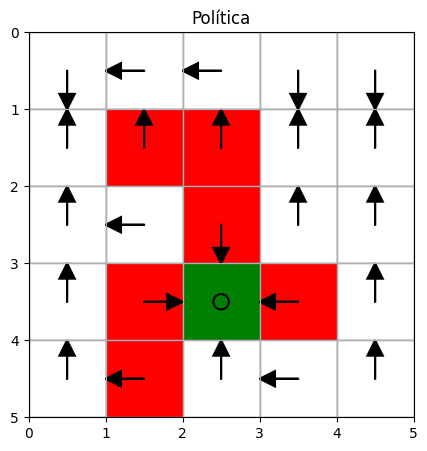

In [74]:
plot_valores_de_estado(V1, ambiente)
plot_policy(ambiente, politica1)

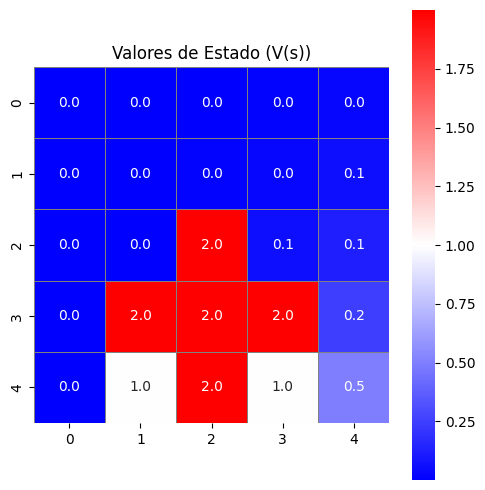

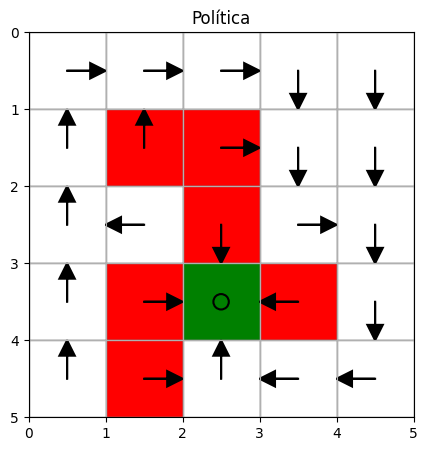

In [75]:
plot_valores_de_estado(V2, ambiente)
plot_policy(ambiente, politica2)

In [ ]:
plot_valores_de_estado(V3, ambiente)
plot_policy(ambiente, politica3)

# Influ√™ncia de recompensas negativas

# Influ√™ncia de alterar as recompensas